In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import SCORERS

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("pulsar_stars.csv")
df = pd.DataFrame(data)
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [12]:
print("Target_0: %.4f%%" % (len(df[df["target_class"]==0]) / len(df) * 100))
print("Target_1: %.4f%%" % (len(df[df["target_class"]==1]) / len(df) * 100))

Target_0: 90.8426%
Target_1: 9.1574%


In [3]:
X = df.drop(["target_class"], axis=1)
y = df["target_class"]

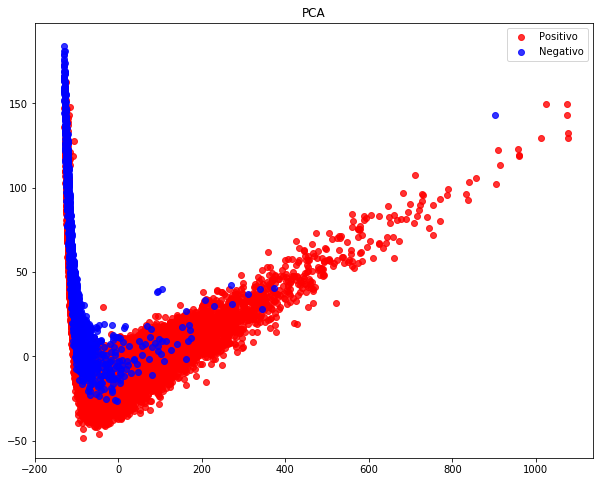

In [4]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

colors = ['red', 'blue']
plt.figure(figsize=(10,8))
plt.scatter(X_r[y == 0, 0], X_r[y == 0, 1], color=colors[0], alpha=.8, label="Positivo")
plt.scatter(X_r[y == 1, 0], X_r[y == 1, 1], color=colors[1], alpha=.8, label="Negativo")
plt.legend(loc="best")
plt.title('PCA')
plt.show()

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X_s = scaler.transform(X)

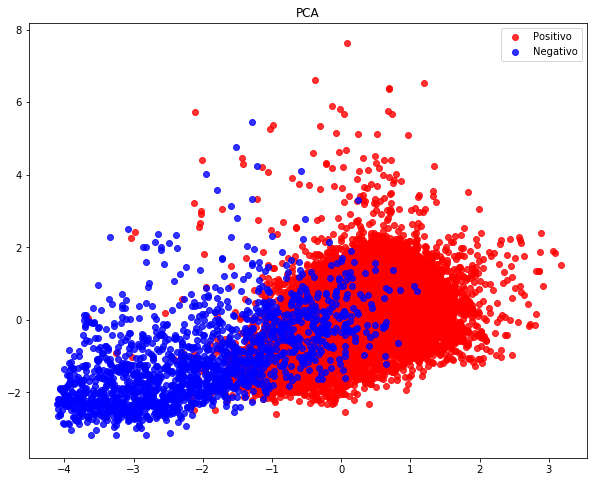

In [6]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_s)

colors = ['red', 'blue']
plt.figure(figsize=(10,8))
plt.scatter(X_s[y == 0, 0], X_s[y == 0, 1], color=colors[0], alpha=.8, label="Positivo")
plt.scatter(X_s[y == 1, 0], X_s[y == 1, 1], color=colors[1], alpha=.8, label="Negativo")
plt.title('PCA')
plt.legend()
plt.show()

##### GridSearchCV + Knn + SelectKBest

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
pipeline = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif)), ('clf', KNeighborsClassifier(weights="distance"))])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1)),
    'clf__n_neighbors': np.asarray(range(1, X_s.shape[1] + 1))
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_ )

{'clf__n_neighbors': 7, 'kbest__k': 5}


In [31]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=5)), ('clf', KNeighborsClassifier(n_neighbors=7, weights="distance"))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=5)), ('clf', KNeighborsClassifier(n_neighbors=7, weights="distance"))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8390 (+/- 0.0096) [Não normalizado]
f-score: 0.8719 (+/- 0.0114) [Normalizado]


##### GridSearchCV + Knn + PCA

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(whiten=True)), ('clf', KNeighborsClassifier(weights="distance"))])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
    'clf__n_neighbors': np.asarray(range(1, X_s.shape[1] + 1))
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'clf__n_neighbors': 5, 'pca__n_components': 8}


In [27]:
clf = Pipeline([('pca', PCA(n_components=8, whiten=True)), ('clf', KNeighborsClassifier(n_neighbors=5, weights="distance"))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', KNeighborsClassifier(n_neighbors=5, weights="distance"))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8770 (+/- 0.02) [Não normalizado]
f-score: 0.8770 (+/- 0.02) [Normalizado]


##### GridSearchCV + LogisticRegression + SelectKBest

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42)
pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('lr', lr)])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1)),
    'lr__max_iter': [10, 100, 1000, 2000, 5000, 10000]
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'kbest__k': 5, 'lr__max_iter': 10}


In [32]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=5)), ('clf', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=5)), ('clf', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8078 (+/- 0.0258) [Não normalizado]
f-score: 0.8711 (+/- 0.0180) [Normalizado]


##### GridSearchCV + LogisticRegression + PCA

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42)
pipeline = Pipeline([('pca', PCA(whiten=True)), ('lr', lr)])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
    'lr__max_iter': [10, 100, 1000, 2000, 5000, 10000]
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'lr__max_iter': 10, 'pca__n_components': 8}


In [35]:
clf = Pipeline([('pca', PCA(n_components=8, whiten=True)), ('clf', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8757 (+/- 0.0153) [Não normalizado]
f-score: 0.8757 (+/- 0.0153) [Normalizado]


##### GridSearchCV + GaussianNB + KBest

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)

pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('gnb', GaussianNB())])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1))
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'kbest__k': 1}


In [38]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=1)), ('clf', GaussianNB())])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=1)), ('clf', GaussianNB())])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8538 (+/- 0.0121) [Não normalizado]
f-score: 0.8538 (+/- 0.0121) [Normalizado]


##### GridSearchCV + GaussianNB + PCA

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
pipeline = Pipeline([('pca', PCA(whiten=True)), ('gnb', GaussianNB())])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'pca__n_components': 1}


In [42]:
clf = Pipeline([('pca', PCA(n_components=1, whiten=True)), ('clf', GaussianNB())])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=1, whiten=True)), ('clf', GaussianNB())])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.0000 (+/- 0.0000) [Não normalizado]
f-score: 0.7448 (+/- 0.0409) [Normalizado]


##### GridSearchCV + RandomForestClassifier + KBest

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)

pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('rf', RandomForestClassifier(random_state=42))])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1)),
    "rf__n_estimators": np.arange(10, 101, 10)
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'kbest__k': 8, 'rf__n_estimators': 90}


In [46]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=8)), ('clf', RandomForestClassifier(random_state=42, n_estimators=90))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=8)), ('clf', RandomForestClassifier(random_state=42, n_estimators=90))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8761 (+/- 0.0152) [Não normalizado]
f-score: 0.8761 (+/- 0.0152) [Normalizado]


##### GridSearchCV + RandomForestClassifier + PCA

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)

pipeline = Pipeline([('pca', PCA(whiten=True)), ('rf', RandomForestClassifier(random_state=42))])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
    "rf__n_estimators": np.arange(10, 101, 10)
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'pca__n_components': 7, 'rf__n_estimators': 60}


In [53]:
clf = Pipeline([('pca', PCA(n_components=7, whiten=True)), ('clf', RandomForestClassifier(n_estimators=60, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=7, whiten=True)), ('clf', RandomForestClassifier(n_estimators=60, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8629 (+/- 0.0166) [Não normalizado]
f-score: 0.8792 (+/- 0.0150) [Normalizado]


##### GridSearchCV + ExtraTreesClassifier + KBest

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
ex = ExtraTreesClassifier(max_depth=None, random_state=42)

pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('ex', ex)])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1)),
    "ex__n_estimators": np.arange(10, 101, 10),
    "ex__min_samples_split": np.asarray([2,3,5,10])
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'ex__min_samples_split': 3, 'ex__n_estimators': 40, 'kbest__k': 4}


In [55]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=4)), ('clf', ExtraTreesClassifier(n_estimators=40, min_samples_split=3, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=4)), ('clf', ExtraTreesClassifier(n_estimators=40, min_samples_split=3, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8751 (+/- 0.0088) [Não normalizado]
f-score: 0.8751 (+/- 0.0088) [Normalizado]


##### GridSearchCV + ExtraTreesClassifier + PCA

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
ex = ExtraTreesClassifier(max_depth=None, random_state=42)

pipeline = Pipeline([('pca', PCA()), ('ex', ex)])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
    "ex__n_estimators": np.arange(10, 101, 10),
    "ex__min_samples_split": np.asarray([2,3,5,10])
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'ex__min_samples_split': 2, 'ex__n_estimators': 100, 'pca__n_components': 8}


In [57]:
clf = Pipeline([('pca', PCA(n_components=8, whiten=True)), ('clf', ExtraTreesClassifier(n_estimators=100, min_samples_split=2, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', ExtraTreesClassifier(n_estimators=100, min_samples_split=2, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8809 (+/- 0.0186) [Não normalizado]
f-score: 0.8810 (+/- 0.0198) [Normalizado]


##### GridSearchCV + DecisionTreeClassifier + KBest

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
dt = DecisionTreeClassifier(max_depth=None, random_state=42)

pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('dt', dt)])
parameters = {
    'kbest__k': np.asarray(range(1, X_s.shape[1] + 1)),
    "dt__min_samples_split": np.asarray([10,50,100, 1000, 5000, 10000])
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'dt__min_samples_split': 5000, 'kbest__k': 1}


In [61]:
clf = Pipeline([('kbest', SelectKBest(f_classif, k=4)), ('clf', DecisionTreeClassifier(min_samples_split=5000, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('kbest', SelectKBest(f_classif, k=4)), ('clf', DecisionTreeClassifier(min_samples_split=5000, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8667 (+/- 0.0134) [Não normalizado]
f-score: 0.8667 (+/- 0.0134) [Normalizado]


##### GridSearchCV + DecisionTreeClassifier + PCA

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42, stratify=y)
dt = DecisionTreeClassifier(max_depth=None, random_state=42)

pipeline = Pipeline([('pca', PCA()), ('dt', dt)])
parameters = {
    'pca__n_components': np.asarray(range(1, X_s.shape[1] + 1)),
    "dt__min_samples_split": np.asarray([10,50,100, 1000, 5000, 10000])
}
clf = GridSearchCV(pipeline, parameters, cv=3, iid=False, scoring="f1")
clf.fit(X_train, y_train)
print(clf.best_params_)

{'dt__min_samples_split': 100, 'pca__n_components': 8}


In [64]:
clf = Pipeline([('pca', PCA(n_components=8, whiten=True)), ('clf', DecisionTreeClassifier(min_samples_split=100, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Não normalizado]" % (scores.mean(), scores.std()))

clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', DecisionTreeClassifier(min_samples_split=100, max_depth=None, random_state=42))])
scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f) [Normalizado]" % (scores.mean(), scores.std()))

f-score: 0.8425 (+/- 0.0202) [Não normalizado]
f-score: 0.8436 (+/- 0.0026) [Normalizado]


##### GridSearchCV + Ensemble + PCA

In [18]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=[('et', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', ExtraTreesClassifier(n_estimators=100, min_samples_split=2, max_depth=None, random_state=42))])), 
                                    ('rf', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=7, whiten=True)), ('clf', RandomForestClassifier(n_estimators=60, random_state=42))])),
                                    ('knn', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=8, whiten=True)), ('clf', KNeighborsClassifier(n_neighbors=5, weights="distance"))]))], 
                                    voting='hard')

scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
print("f-score: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

f-score: 0.8807 (+/- 0.0165)


# Conclusão

Notamos que, através dos algorítmos utilizados, o ExtraTrees foi o que apresentou melhor desempenho. Entretanto, devido ao custo computacional, provou-se mais relevante utilizar em ambiente de produção o algorítmo RandomForest, devido ao menor tempo de execução.

Em quase todos os testes, a utilização do PCA trouxe desempenho superior ao entregue pelo SelectKBest. Isso se deu provavelmente pelos atributos utilizados, que compõe basicamente de médias e métricas estatísticas.

Visualmente a distribuição dos dados normalizados foi mais homogênea, sugerindo que o desempenho seria melhor utilizando essa técnica. Isso se provou nos testes, com os resultados utilizando dados não normalizados entregando desempenho inferior.

A utilização do comitê de máquinas tambpem foi satisfatória, porém o tempo foi o fator decisivo, já que os resultados não foram significativamente superiores.
